In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow import keras
import keras
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.visualization import get_num_filters
from vis.visualization import visualize_saliency_init
from vis.visualization import visualize_saliency_run
from vis.utils import utils
from tqdm import tqdm
from scipy.stats import describe
from scipy import ndimage
import os
import imageio

/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


# 1. Loading Data 

## Read dataset

In [2]:
tf.enable_eager_execution()

In [3]:
data = tfds.load("svhn_cropped", split = ['train','test'])

In [4]:
tf.executing_eagerly()

True

In [5]:
print(data)

[<DatasetV1Adapter shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>, <DatasetV1Adapter shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>]


In [6]:
train, test = data

Label: 5


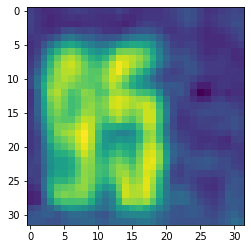

In [7]:
for example in train.take(1):  # Only take a single example
  image, label = example["image"], example["label"]

  plt.imshow(image.numpy()[:, :, 1].astype(np.float32))
  print("Label: %d" % label.numpy())

In [8]:
train = np.array(list(tfds.as_numpy(train)))
test = np.array(list(tfds.as_numpy(test)))

In [9]:
train[7]["label"]

7

In [10]:
trainX = np.array([inst['image'] for inst in train])
trainY = np.array([inst['label'] for inst in train])
testX = np.array([inst['image'] for inst in test])
testY = np.array([inst['label'] for inst in test])

In [11]:
np.shape(trainX)

(73257, 32, 32, 3)

In [12]:
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

In [13]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [14]:
print(trainX.shape)

(73257, 32, 32, 3)


In [15]:
describe(testX,axis=None)

DescribeResult(nobs=79970304, minmax=(0.0, 1.0), mean=0.45796666, variance=0.050627448, skewness=0.26756078004837036, kurtosis=-0.6019900844592385)

# Training

## Code for training

In [16]:
tf.compat.v1.disable_eager_execution()

In [17]:
#Creates Sequential model using Keras
#Number of nodes is the same as number of features (different number of nodes were tried but it did not
#affect validation accuracy significantly)
lenet = keras.Sequential([
                            #Input layer:
                            keras.layers.Conv2D(20, 5, padding="same", input_shape=[32,32,3], use_bias=True),
                            #Hidden Layers:
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Conv2D(50, 5, padding="same"),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Flatten(),
                            keras.layers.Dense(500),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.Dense(10, name='vis',use_bias=True),
                            #Output layer
                            keras.layers.Activation(activation="softmax"),
                        ])

In [18]:
#lenets = [keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet)]

In [19]:
classifier_number = 5
lenets = [keras.models.clone_model(lenet)]
for i in range(1,classifier_number):
    lenets.append(keras.models.clone_model(lenet))

In [20]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
lenet.compile(
                optimizer=keras.optimizers.SGD(lr=0.01),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy']
                )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
lenetEpochHistory = lenet.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 73257 samples, validate on 26032 samples
Epoch 1/5
73257/73257 [==============================] - 19s 261us/step - loss: 1.7642 - acc: 0.3979 - val_loss: 1.6302 - val_acc: 0.4880
Epoch 2/5
73257/73257 [==============================] - 16s 213us/step - loss: 0.6505 - acc: 0.8137 - val_loss: 0.6155 - val_acc: 0.8254
Epoch 3/5
73257/73257 [==============================] - 16s 212us/step - loss: 0.4995 - acc: 0.8597 - val_loss: 0.5069 - val_acc: 0.8604
Epoch 4/5
73257/73257 [==============================] - 15s 210us/step - loss: 0.4330 - acc: 0.8777 - val_loss: 0.5036 - val_acc: 0.8601
Epoch 5/5
73257/73257 [==============================] - 15s 211us/step - loss: 0.3859 - acc: 0.8902 - val_loss: 0.4541 - val_acc: 0.8757


In [21]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
for model in lenets:
    model.compile(
                    optimizer=keras.optimizers.SGD(lr=0.01),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
                    )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
for model in lenets:
    model.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))

Train on 73257 samples, validate on 26032 samples
Epoch 1/5
73257/73257 [==============================] - 17s 227us/step - loss: 1.9018 - acc: 0.3414 - val_loss: 1.0731 - val_acc: 0.6744
Epoch 2/5
73257/73257 [==============================] - 16s 220us/step - loss: 0.7575 - acc: 0.7760 - val_loss: 0.7148 - val_acc: 0.7844
Epoch 3/5
73257/73257 [==============================] - 16s 219us/step - loss: 0.5472 - acc: 0.8451 - val_loss: 0.6043 - val_acc: 0.8316
Epoch 4/5
73257/73257 [==============================] - 16s 220us/step - loss: 0.4600 - acc: 0.8699 - val_loss: 0.5174 - val_acc: 0.8570
Epoch 5/5
73257/73257 [==============================] - 16s 219us/step - loss: 0.4044 - acc: 0.8852 - val_loss: 0.5534 - val_acc: 0.8424
Train on 73257 samples, validate on 26032 samples
Epoch 1/5
73257/73257 [==============================] - 16s 225us/step - loss: 1.8525 - acc: 0.3624 - val_loss: 1.1044 - val_acc: 0.6644
Epoch 2/5
73257/73257 [==============================] - 16s 217us/step 

# General Evaluation

In [22]:
#Predicting Label:

print(np.argmax(lenet.predict(testX)[100]))
print(np.argmax(testY[100]))

5
5


26032/26032 [==============================] - 2s 84us/step
Lenet accuracy:  0.8757298709280885
Lenet loss:  0.4540770964693569


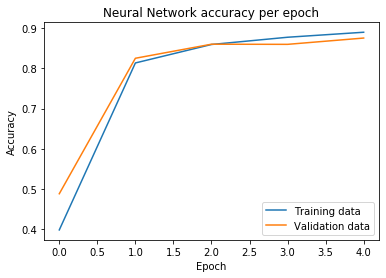

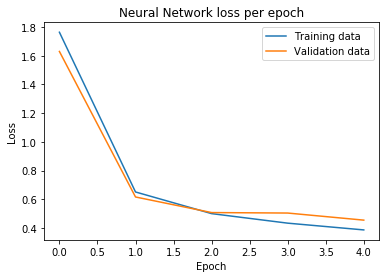

In [23]:
#Get accuracy for lenet
sequentialLoss, sequentialAccuracy = lenet.evaluate(testX, testY)
print('Lenet accuracy: ', sequentialAccuracy)
print('Lenet loss: ', sequentialLoss)

plt.plot(lenetEpochHistory.history['acc'])
plt.plot(lenetEpochHistory.history['val_acc'])
plt.title('Neural Network accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

plt.plot(lenetEpochHistory.history['loss'])
plt.plot(lenetEpochHistory.history['val_loss'])
plt.title('Neural Network loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

# Saliency

In [25]:
#This line outputs the layer_idx that the saliency is meant to be extracted from. (Usually the output layer pre-activation)
utils.find_layer_idx(lenet, 'vis')

9

In [26]:
#Check if that layer is correct by checking if the number of nodes matches the number of outputs
get_num_filters(lenet.layers[9])

10

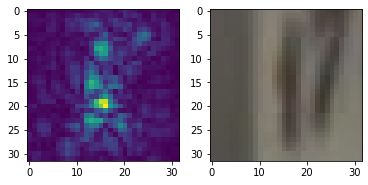

In [27]:
#Check if the saliency map is working for the singular network
input_idx = 1
fig, ax = plt.subplots(nrows=1, ncols=2)
saliency_map = visualize_saliency(model = lenet,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx])
ax[0].imshow(saliency_map.reshape(32,32),interpolation='nearest')
ax[1].imshow(testX[input_idx].reshape(32,32,3))
plt.show()

In [28]:
# Get optimisers for each network's output node to speed up saliency processing
optimisers = []
classifiers = lenets
for i in range(0,len(classifiers)):
    classifier_optmisers = []
    for j in range(0,10):
        opt = visualize_saliency_init(classifiers[i],9,filter_indices=j)
        classifier_optmisers.append(opt)
    optimisers.append(classifier_optmisers)
        

In [29]:
#Function to calculate ensemble outputs (for series of inputs) using mean of outputs
def get_ensenmble_outputs(classifiers,classifier_inputs,number_of_outputs):
    predictions = np.zeros((np.size(classifier_inputs, axis=0), np.size(number_of_outputs)))
    for classifier in classifiers:
        predictions = predictions + classifier.predict(classifier_inputs)
    prediction_average = predictions / classifier_number
    outputs = np.apply_along_axis(np.argmax, axis=1, arr=prediction_average)
    return(outputs)
        

In [30]:
#Function to calculate ensemble output (for one input) using mean of outputs
def get_ensemble_output(classifiers,classifier_input,number_of_outputs):
    predictions = np.zeros(np.size(number_of_outputs))
    for classifier in classifiers:
        predictions = predictions + classifier.predict(np.expand_dims(classifier_input,axis=0))
    prediction_average = predictions / classifier_number
    output = np.argmax(prediction_average)
    return(output)
        

In [31]:
get_ensemble_output(lenets,testX[100],10)

5

In [32]:
correct = 0
for i in range(0,len(testX)):
    if (get_ensemble_output(lenets,testX[i],10) == np.argmax(testY[i])):
        correct = correct + 1

In [33]:
print(correct)
print(len(testX))

23023
26032


In [34]:
# Function to generate multiple saliency maps for each input

# If doing this over multiple inputs at a time, it is faster to go over multiple inputs
# with the same classifier and then doing the same for the different classifiers. This is 
# because switching optimisers is computationally expensive.

def generate_saliency_maps_for_one_input(classifiers,classifier_input,optimisers,visualised_layer):
    output_node = get_ensemble_output(classifiers,classifier_input,len(optimisers))
    saliency_maps = np.zeros((len(classifiers),classifier_input.shape[0],classifier_input.shape[1]))
    for i in range(0,len(classifiers)):
        saliency_maps[i] = visualize_saliency_run(model = classifiers[i],layer_idx = visualised_layer, opt = optimisers[i][output_node], seed_input = classifier_input)
    return(saliency_maps)
    

In [35]:
#Function to visualise the multiple saliency maps
def visualize_saliency_maps(classifier_input,saliency_maps):
    fig, ax = plt.subplots(nrows=1, ncols=len(saliency_maps)+1, figsize = (15,15))
    i = 1
    for s_map in saliency_maps:
        ax[i].imshow(s_map)
        i = i+1
    ax[0].imshow(classifier_input)
    plt.show()

In [36]:
# Compute difference of saliency maps
def generate_uncertainty_map(saliency_maps):
    return(np.std(saliency_maps,axis=0)/np.average(saliency_maps,axis=0))

In [37]:
# Wrapper function to arrive at uncertainty output using classifiers and input
def calculate_uncertainty(classifiers,classifier_input,optimisers,visualised_layer):
    
    saliency_maps = generate_saliency_maps_for_one_input(classifiers = classifiers,
                                  classifier_input = classifier_input,
                                  optimisers = optimisers,
                                  visualised_layer = visualised_layer)
    
    uncertainty_map = generate_uncertainty_map(saliency_maps)
    
    return(np.average(uncertainty_map))


In [38]:
# Compute difference of saliency maps
def calculate_uncertainty_with_maps(saliency_maps):
    return(np.mean(np.std(saliency_maps,axis=0)/np.average(saliency_maps,axis=0)))

In [39]:
def generate_saliency_maps_for_multiple_inputs(classifier,classifier_inputs,classifier_outputs,
                                               classifier_optimisers,visualised_layer):
    
    saliency_maps = []
    for input_idx in tqdm(range(0,np.size(classifier_inputs,axis=0))):
        classifier_input = classifier_inputs[input_idx]
        output_node = classifier_outputs[input_idx]
        saliency_maps.append(visualize_saliency_run(model = classifier,
                                                    layer_idx = 9, 
                                                    opt = classifier_optimisers[output_node],   
                                                    seed_input = classifier_input))
    return(saliency_maps)


In [40]:
def generate_ensemble_saliency_maps_for_multiple_inputs(classifiers,
                                                        classifier_inputs,classifier_outputs,
                                                        optimisers,visualised_layer):
    saliency_maps = []
    for classifier_idx in range(0,len(classifiers)):
        saliency_maps.append(generate_saliency_maps_for_multiple_inputs(
                                classifiers[classifier_idx],
                                classifier_inputs,
                                classifier_outputs,
                                optimisers[classifier_idx],
                                9))
    return(saliency_maps)
    

# MNIST

In [41]:
MNIST_ensemble_predicted_outputs = get_ensenmble_outputs(lenets, testX,10)

In [42]:
# Generate saliency maps examples
input_idx = 1
maps = generate_saliency_maps_for_one_input(classifiers = lenets,
                                            classifier_input = testX[input_idx],
                                            optimisers = optimisers,
                                            visualised_layer = 9)

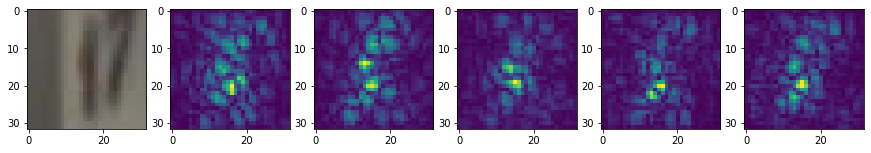

In [43]:
# Visualise saliency maps examples
visualize_saliency_maps(classifier_input = testX[input_idx].reshape(32,32,3),
                        saliency_maps = maps)

In [44]:
for mapx in maps:
    print(describe(mapx,axis=None))

DescribeResult(nobs=1024, minmax=(0.0, 0.9999998807907104), mean=0.12792079595087102, variance=0.0170123257858514, skewness=2.1790803129070473, kurtosis=6.620933458020604)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998807907104), mean=0.12295046078435234, variance=0.018370001177881925, skewness=2.497011057362971, kurtosis=8.155779827413372)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998807907104), mean=0.09845377319788895, variance=0.01215339734847956, skewness=3.176326463191577, kurtosis=14.584482403031679)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998807907104), mean=0.09734616285658149, variance=0.011681232979426998, skewness=3.27218278405605, kurtosis=16.562940968686355)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998807907104), mean=0.10785843135579398, variance=0.014410939378111994, skewness=2.8311815403434544, kurtosis=11.420884746973803)


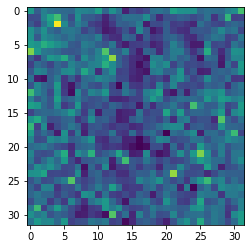

In [45]:
# Visualise uncertainty map example
uncertainty_map = generate_uncertainty_map(maps)
plt.imshow(uncertainty_map)
plt.show()

In [46]:
describe(uncertainty_map,axis=None)

DescribeResult(nobs=1024, minmax=(0.10213731648593498, 1.4368504661690307), mean=0.5225563051089794, variance=0.03504102478751463, skewness=0.515477949039703, kurtosis=0.7264498305875686)

In [47]:
# Compute the average difference value for each pixel (uncertainty)
np.average(uncertainty_map)

0.5225563051089794

In [48]:
# Generating example using wrapper function
input_idx = 4
uncertainty = calculate_uncertainty(classifiers = lenets,
                              classifier_input = testX[input_idx],
                              optimisers = optimisers,
                              visualised_layer = 9)
print(uncertainty)

0.5303778983193623


generate_saliency_maps_for_multiple_inputs(lenets[0],testX,ensemble_predicted_outputs,optimisers[0],9)

In [49]:
MNIST_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(lenets,testX,MNIST_ensemble_predicted_outputs,optimisers,9)

100%|██████████| 26032/26032 [01:34<00:00, 276.39it/s]


In [50]:
MNIST_saliency_maps = np.swapaxes(MNIST_saliency_maps,0,1)

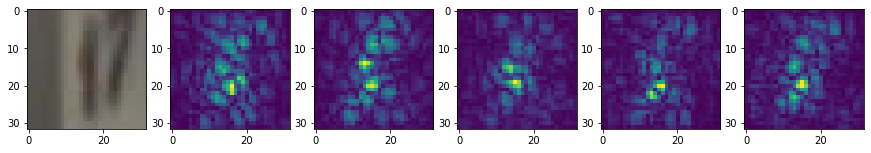

In [51]:
visualize_saliency_maps(testX[1].reshape(32,32,3),MNIST_saliency_maps[1])

In [52]:
MNIST_uncertainties = np.zeros(np.size(MNIST_saliency_maps,axis=0))
for i in range(0,np.size(MNIST_saliency_maps, axis=0)):
    MNIST_uncertainties[i] = calculate_uncertainty_with_maps(MNIST_saliency_maps[i])

In [53]:
MNIST_uncertainties[6]

0.5158345103263855

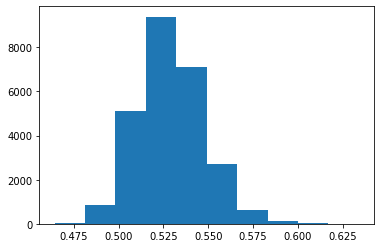

In [54]:
plt.hist(MNIST_uncertainties)
plt.savefig("SVHN_uncertainties.png")
plt.show()

In [55]:
describe(MNIST_uncertainties)

DescribeResult(nobs=26032, minmax=(0.4643207788467407, 0.6340411901473999), mean=0.5290794368551675, variance=0.00034502571660567015, skewness=0.46033680080304895, kurtosis=0.6285538783595879)

# Not-MNIST

In [56]:
data_cifar = tf.keras.datasets.cifar10.load_data()

In [57]:
np.shape(data_cifar[1][0])

(10000, 32, 32, 3)

In [58]:
data_cifar = np.concatenate((data_cifar[0][0],data_cifar[1][0]))

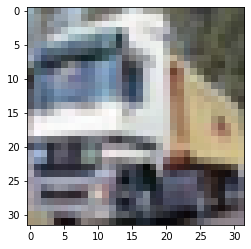

In [59]:
plt.imshow(data_cifar[1])
plt.show()

In [60]:
describe(data_cifar,axis=None)

DescribeResult(nobs=184320000, minmax=(0, 255), mean=120.84449672851562, variance=4113.421953185807, skewness=0.21918106646988617, kurtosis=-0.7942807501463967)

In [61]:
data_cifar = data_cifar.astype("float32") / 255.0

In [62]:
describe(data_cifar,axis=None)

DescribeResult(nobs=184320000, minmax=(0.0, 1.0), mean=0.47389895, variance=0.06325926, skewness=0.21919307112693787, kurtosis=-0.7942882915073182)

In [63]:
NotMNIST_ensemble_predicted_outputs = get_ensenmble_outputs(lenets, data_cifar,10)

In [64]:
NotMNIST_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(lenets,data_cifar,NotMNIST_ensemble_predicted_outputs,optimisers,9)

100%|██████████| 60000/60000 [03:40<00:00, 271.57it/s]


In [65]:
NotMNIST_saliency_maps = np.swapaxes(NotMNIST_saliency_maps,0,1)

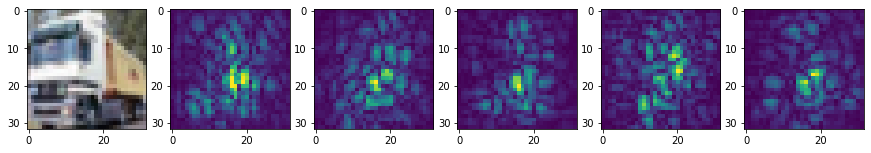

In [66]:
visualize_saliency_maps(data_cifar[1].reshape(32,32,3),NotMNIST_saliency_maps[1])

In [67]:
for mapx in NotMNIST_saliency_maps[1]:
    print(describe(mapx,axis=None))

DescribeResult(nobs=1024, minmax=(0.0, 0.99999976), mean=0.1540072, variance=0.025032543, skewness=2.3973796367645264, kurtosis=7.167797117550807)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998), mean=0.14078349, variance=0.020158337, skewness=2.1368396282196045, kurtosis=5.641140788144536)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999999), mean=0.11194782, variance=0.016163215, skewness=2.527195692062378, kurtosis=8.727447352530106)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998), mean=0.14778914, variance=0.024563778, skewness=2.094128131866455, kurtosis=4.7355747869444365)
DescribeResult(nobs=1024, minmax=(0.0, 0.9999998), mean=0.115295276, variance=0.015085169, skewness=2.6432173252105713, kurtosis=9.984828033156838)


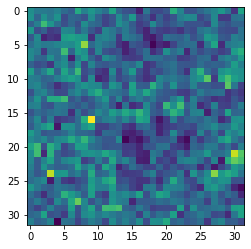

In [68]:
# Visualise uncertainty map example
uncertainty_map = generate_uncertainty_map(NotMNIST_saliency_maps[1])
plt.imshow(uncertainty_map)
plt.show()

In [69]:
describe(uncertainty_map,axis=None)

DescribeResult(nobs=1024, minmax=(0.07025574, 1.4512383), mean=0.5579122, variance=0.040194575, skewness=0.42802953720092773, kurtosis=0.3678301609274124)

In [70]:
NotMNIST_uncertainties = np.zeros(np.size(NotMNIST_saliency_maps,axis=0))
for i in range(0,np.size(NotMNIST_saliency_maps, axis=0)):
    NotMNIST_uncertainties[i] = calculate_uncertainty_with_maps(NotMNIST_saliency_maps[i])

In [71]:
NotMNIST_uncertainties[6]

0.548844575881958

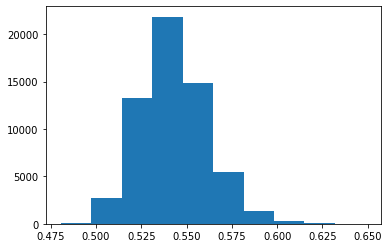

In [72]:
plt.hist(NotMNIST_uncertainties)
plt.savefig("CIFAR10_uncertainties.png")
plt.show()

In [73]:
describe(NotMNIST_uncertainties)

DescribeResult(nobs=60000, minmax=(0.48068466782569885, 0.6486691236495972), mean=0.5429443788955609, variance=0.00034733517774912656, skewness=0.46552481764882025, kurtosis=0.6085262819049602)

# Misc.

In [74]:
#This prints out the pre-activation outputs for the output layer (for curiosity)
intermediate_layer_model = keras.Model(inputs=lenet.input,
                                 outputs=lenet.get_layer("vis").output)
intermediate_output = intermediate_layer_model.predict(testX)[input_idx]
print(max(intermediate_output))
print(lenet.predict(testX)[input_idx])

9.182341
[2.8073987e-06 1.2493449e-04 9.9524915e-01 1.8336752e-03 4.2502265e-04
 9.9248234e-07 1.6648237e-06 2.0413329e-03 2.9920906e-04 2.1296415e-05]


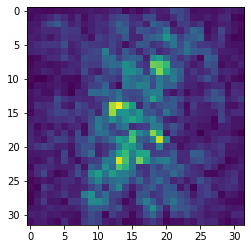

In [75]:
# This is what happens if we don't normalise the pixels' standard deviation
plt.imshow(np.std(maps,axis=0))
plt.show()

In [76]:
#Output images that were misclassified by the singular classifier
idx = 0
for i in lenet.predict(testX):
    if (np.argmax(i) != np.argmax(testY[idx])):
        print(idx)
    idx = idx + 1

2
24
27
48
55
63
70
75
98
102
123
130
146
167
176
180
181
186
194
200
206
210
219
223
253
260
263
273
284
285
311
336
337
338
339
349
360
366
368
371
374
378
392
397
399
400
404
408
412
435
439
442
445
446
447
454
481
503
508
511
527
528
570
581
585
597
598
610
611
612
622
639
644
657
660
666
678
679
682
695
696
708
710
711
716
735
736
740
742
748
751
754
757
762
766
773
779
794
797
798
810
814
816
830
835
877
882
884
896
926
947
969
972
973
1013
1024
1025
1027
1029
1033
1039
1040
1041
1056
1084
1091
1094
1098
1117
1120
1122
1124
1128
1134
1138
1142
1154
1167
1170
1174
1177
1199
1203
1204
1210
1226
1235
1245
1253
1260
1264
1282
1283
1292
1302
1311
1313
1335
1341
1345
1361
1364
1369
1375
1377
1387
1392
1397
1398
1405
1407
1423
1432
1439
1445
1448
1454
1461
1464
1476
1492
1498
1502
1514
1517
1518
1527
1532
1533
1535
1541
1546
1552
1570
1617
1626
1636
1644
1648
1652
1663
1683
1689
1690
1697
1704
1727
1760
1762
1773
1793
1799
1804
1808
1813
1814
1818
1824
1827
1830
1838
1849
1869
1872
1876

18905
18913
18918
18919
18922
18929
18935
18939
18941
18952
18953
18965
18969
18977
18991
18998
19019
19020
19032
19037
19038
19041
19055
19060
19076
19079
19081
19106
19108
19115
19120
19123
19139
19140
19142
19153
19159
19167
19190
19191
19194
19205
19212
19234
19235
19238
19244
19255
19262
19264
19267
19272
19274
19278
19281
19307
19348
19349
19353
19356
19367
19372
19376
19378
19394
19398
19399
19407
19418
19423
19435
19446
19448
19449
19457
19462
19470
19472
19476
19482
19512
19513
19518
19520
19521
19530
19545
19552
19554
19555
19570
19571
19575
19598
19605
19625
19631
19656
19659
19663
19665
19681
19685
19710
19713
19726
19746
19748
19752
19754
19760
19765
19782
19783
19786
19787
19791
19813
19819
19822
19833
19835
19836
19839
19852
19863
19890
19891
19893
19903
19904
19911
19914
19916
19917
19934
19938
19940
19958
19960
19983
19990
19995
20000
20032
20054
20065
20082
20084
20088
20092
20103
20107
20123
20133
20171
20188
20191
20195
20203
20210
20223
20244
20245
20248
20260
2026